In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import seaborn as sns
import numpy as np

from sklearn.cluster import KMeans
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, learning_curve, cross_val_score
from sklearn.ensemble import RandomForestClassifier
# sklearn.metrics의 모든 필요한 함수들을 한 줄로 임포트
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, silhouette_samples, silhouette_score

from scipy.stats import boxcox

import warnings
import matplotlib.cm as cm
from sklearn.preprocessing import StandardScaler


# 1. 한글 폰트 설정 (예: 맑은 고딕)
plt.rcParams['font.family'] = 'Malgun Gothic'

# 2. 마이너스 깨짐 방지
plt.rcParams['axes.unicode_minus'] = False

# 데이터 전처리

In [2]:
df = pd.read_csv('../data/Sleep_health_and_lifestyle_dataset.csv')

In [3]:
df.head()

,Person ID,Gender,Age,Occupation,Sleep Duration,Quality of Sleep,Physical Activity Level,Stress Level,BMI Category,Blood Pressure,Heart Rate,Daily Steps,Sleep Disorder
0,1,Male,27,Software Engineer,6.1,6,42,6,Overweight,126/83,77,4200,NaN
1,2,Male,28,Doctor,6.2,6,60,8,Normal,125/80,75,10000,NaN
2,3,Male,28,Doctor,6.2,6,60,8,Normal,125/80,75,10000,NaN
3,4,Male,28,Sales Representative,5.9,4,30,8,Obese,140/90,85,3000,Sleep Apnea
4,5,Male,28,Sales Representative,5.9,4,30,8,Obese,140/90,85,3000,Sleep Apnea


In [4]:
# df_new.head()

In [5]:
df['BMI Category'].unique()

array(['Overweight', 'Normal', 'Obese', 'Normal Weight'], dtype=object)

## Normal Weight와 Normal 합치기

In [6]:
df['BMI Category'] = df['BMI Category'].replace('Normal Weight', 'Normal')

## Blood Pressure 나누기

In [7]:
if 'Blood Pressure' in df.columns:
        df[['Systolic', 'Diastolic']] = df['Blood Pressure'].str.split('/', expand=True).astype(int)
        df.drop(columns=['Blood Pressure'], inplace=True)

### 여기다가 직업 분류 넣기

## 카테고리컬로 string 없애기

Fmale : 0
Male  : 1

None        : 0
Insomnia    : 1



In [8]:

# Sleep Disorder 제외하고 범주형 컬럼만 선택
cat_cols = [col for col in df.select_dtypes(include='object').columns if col != 'Sleep Disorder']

le_dict = {}
for col in cat_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    le_dict[col] = le  # 나중에 디코딩용 저장


In [9]:
df.head()

,Person ID,Gender,Age,Occupation,Sleep Duration,Quality of Sleep,Physical Activity Level,Stress Level,BMI Category,Heart Rate,Daily Steps,Sleep Disorder,Systolic,Diastolic
0,1,1,27,9,6.1,6,42,6,2,77,4200,NaN,126,83
1,2,1,28,1,6.2,6,60,8,0,75,10000,NaN,125,80
2,3,1,28,1,6.2,6,60,8,0,75,10000,NaN,125,80
3,4,1,28,6,5.9,4,30,8,1,85,3000,Sleep Apnea,140,90
4,5,1,28,6,5.9,4,30,8,1,85,3000,Sleep Apnea,140,90


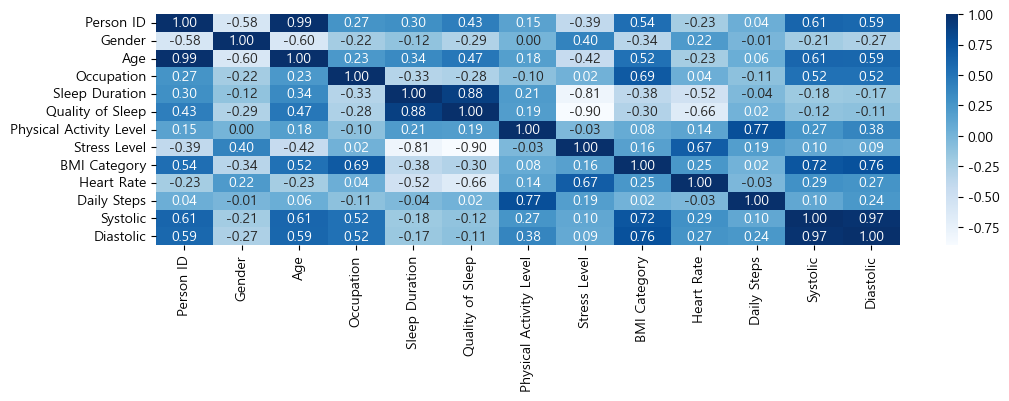

In [10]:
# 숫자형 컬럼만 선택
numeric_df = df.select_dtypes(include=['number'])

# 상관계수 계산
corr_matrix = numeric_df.corr()

# 시각화
plt.figure(figsize=(12, 3))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="Blues")
plt.show()

In [11]:
df['Quality of Sleep'].value_counts()

Quality of Sleep
8    109
6    105
7     77
9     71
5      7
4      5
Name: count, dtype: int64

## 상관계수 낮은 데이터 지우기

In [12]:
cols_to_drop = ['Person ID', 'Daily Steps', 'Sleep Disorder', 'Sleep Duration']
existing_cols = [col for col in cols_to_drop if col in df.columns]
df.drop(existing_cols, axis=1, inplace=True)

In [13]:
print(df.columns)

Index(['Gender', 'Age', 'Occupation', 'Quality of Sleep',
       'Physical Activity Level', 'Stress Level', 'BMI Category', 'Heart Rate',
       'Systolic', 'Diastolic'],
      dtype='object')


In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 374 entries, 0 to 373
Data columns (total 10 columns):
 #   Column                   Non-Null Count  Dtype
---  ------                   --------------  -----
 0   Gender                   374 non-null    int64
 1   Age                      374 non-null    int64
 2   Occupation               374 non-null    int64
 3   Quality of Sleep         374 non-null    int64
 4   Physical Activity Level  374 non-null    int64
 5   Stress Level             374 non-null    int64
 6   BMI Category             374 non-null    int64
 7   Heart Rate               374 non-null    int64
 8   Systolic                 374 non-null    int64
 9   Diastolic                374 non-null    int64
dtypes: int64(10)
memory usage: 29.3 KB


## 학습 데이터 / 타겟 데이터 나누기

In [15]:
# Quality of Sleep을 예측할 때

X = df.drop(['Quality of Sleep'], axis=1)
y = df['Quality of Sleep']

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# 🔁 gubun 재설정 (핵심!)
df['gubun'] = 'train'
df.loc[X_test.index, 'gubun'] = 'test'

## 이상치 제거

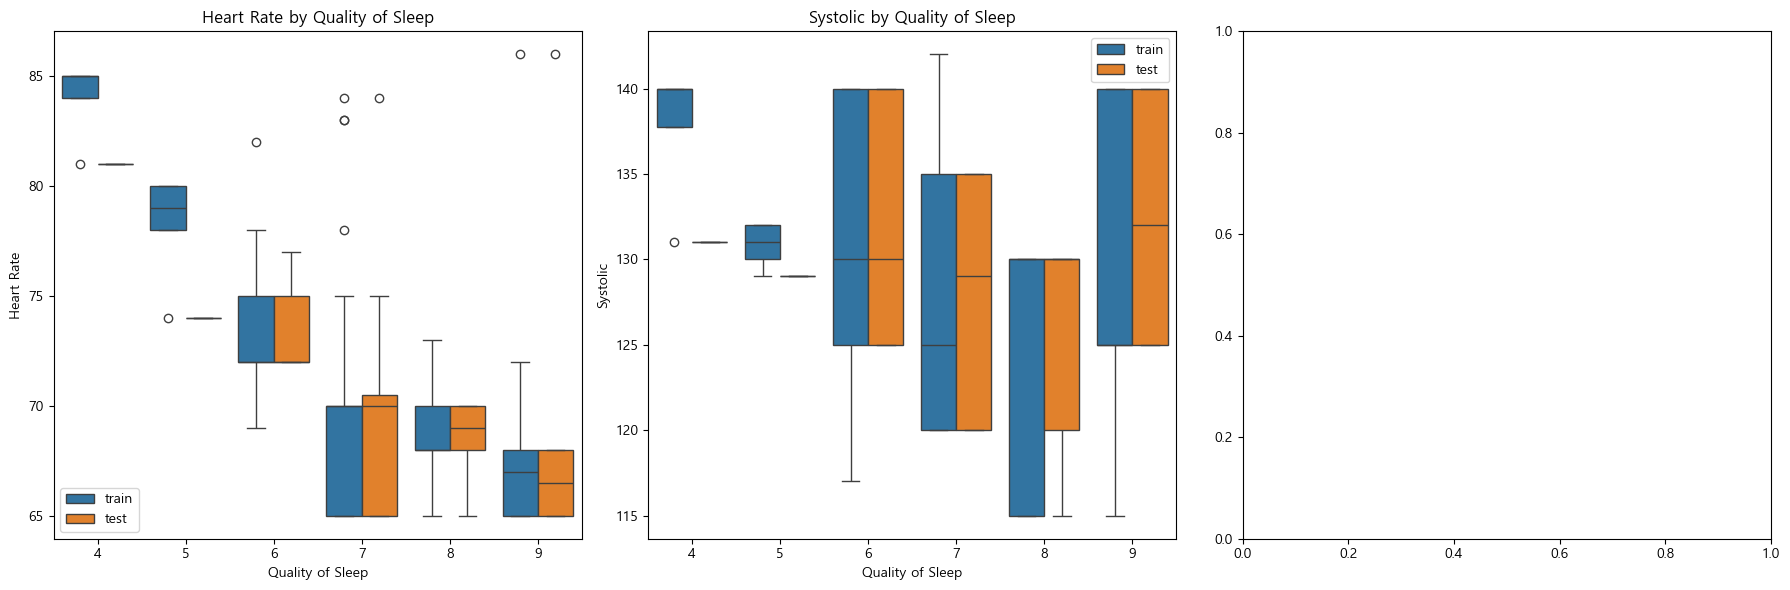

In [16]:
cols = ['Heart Rate', 'Systolic']
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18, 6))  # 1행 3열

for i, col in enumerate(cols):
    sns.boxplot(x="Quality of Sleep", y=col, data=df, hue='gubun', ax=axes[i])
    axes[i].set_title(f"{col} by Quality of Sleep")
    axes[i].legend(loc='best')

plt.tight_layout()
plt.show()

In [17]:
# 이상치 제거 조건 수동 정의
condition = (
    (df['Heart Rate'].between(60, 90)) &
    (df['Systolic'].between(110, 140))
)

df_clean = df[condition].copy()
print(f"\n이상치 제거 전 df 행 수: {len(df)}")
print(f"이상치 제거 후 df_clean 행 수: {len(df_clean)}")


이상치 제거 전 df 행 수: 374
이상치 제거 후 df_clean 행 수: 372


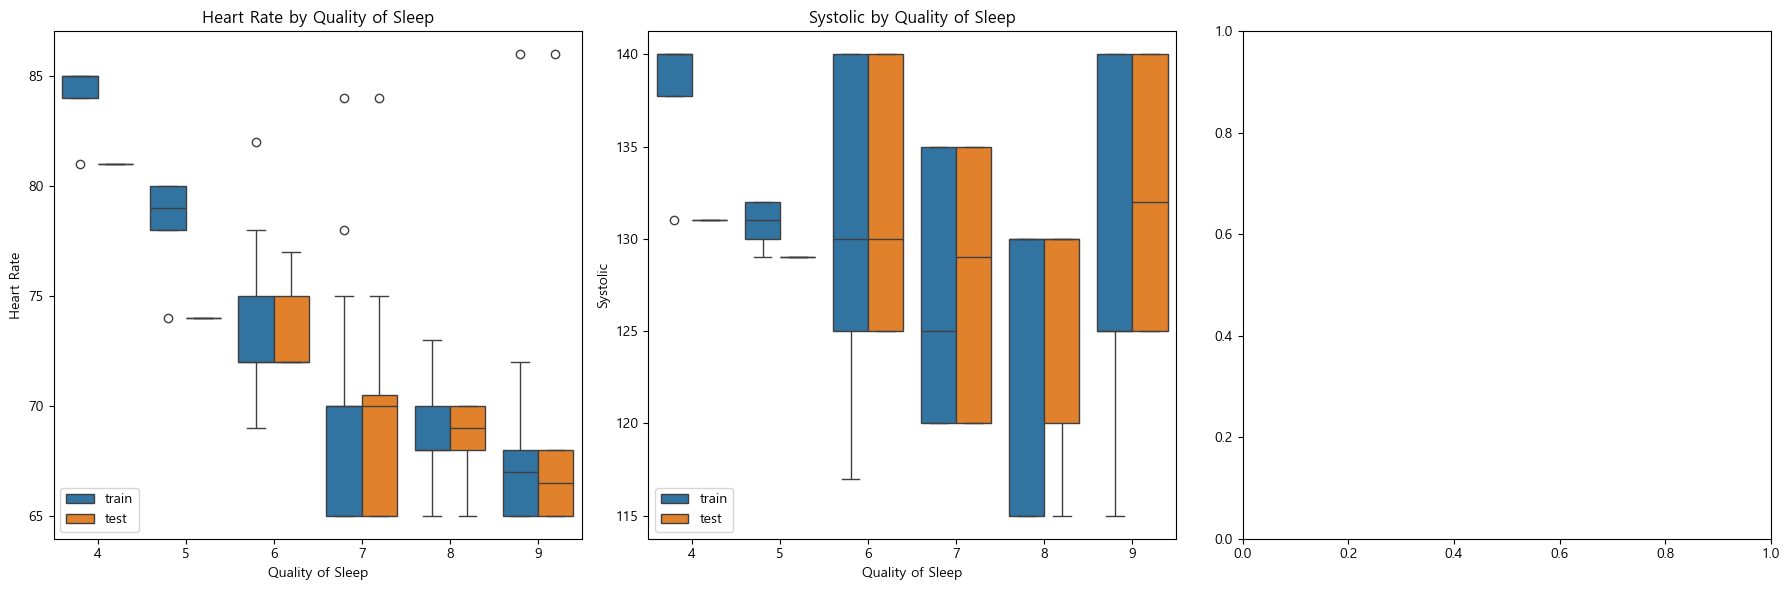

In [18]:
cols = ['Heart Rate', 'Systolic']
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18, 6))  # 1행 3열

for i, col in enumerate(cols):
    sns.boxplot(x="Quality of Sleep", y=col, data=df_clean, hue='gubun', ax=axes[i])
    axes[i].set_title(f"{col} by Quality of Sleep")
    axes[i].legend(loc='best')

plt.tight_layout()
plt.show()


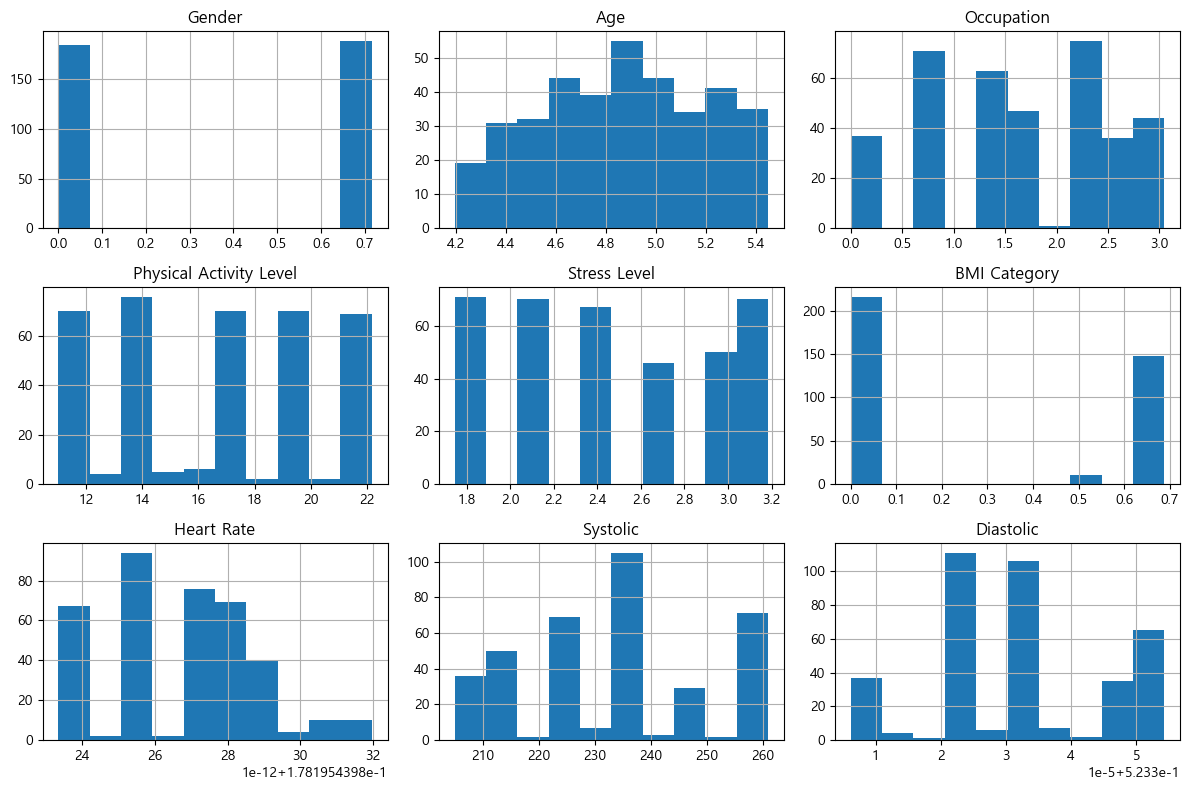

In [19]:
# 수치형 컬럼만 선택
numeric_cols = X.select_dtypes(include=['int64', 'float64']).columns

# boxcox 적용
for col in numeric_cols:
    X[col], _ = boxcox(X[col] + 1)  # +1: 0이나 음수 방지

# 히스토그램 확인
X.hist(figsize=(12, 8))
plt.tight_layout()
plt.show()

In [20]:
# --- 5. 모델 학습 데이터 준비 ---
# [설명]: df_clean에서 'Quality of Sleep'을 타겟(y_model)으로, 나머지를 피처(X_model)로 분리합니다.
X_model = df_clean.drop(['Quality of Sleep', 'gubun'], axis=1, errors='ignore') # 'gubun' 컬럼을 X_model에서 제거합니다.
y_model = df_clean['Quality of Sleep']

# Boxcox 변환 적용 (모델 학습 피처에만)
numeric_cols_model = X_model.select_dtypes(include=['int64', 'float64']).columns
for col in numeric_cols_model:
    # [수정사항]: X[col] -> X_model[col]
    X_model[col], _ = boxcox(X_model[col] + 1) # +1: 0이나 음수 방지

# 모델 학습을 위한 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(
    X_model, y_model, test_size=0.2, random_state=42, stratify=y_model
)
print("\n모델 학습 데이터 준비 완료.")
print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")


모델 학습 데이터 준비 완료.
X_train shape: (297, 9), y_train shape: (297,)


# 모델 학습

In [23]:
# 1. 모델 학습

rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [24]:
# 2. 예측
y_pred = rf_model.predict(X_test)

In [25]:
# 3. 평가

print("\n--- 모델 예측 및 평가 ---")
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))


--- 모델 예측 및 평가 ---
Accuracy: 0.92

Classification Report:
              precision    recall  f1-score   support

           4       1.00      1.00      1.00         1
           5       1.00      0.50      0.67         2
           6       0.88      1.00      0.93        21
           7       1.00      0.80      0.89        15
           8       0.95      0.91      0.93        22
           9       0.88      1.00      0.93        14

    accuracy                           0.92        75
   macro avg       0.95      0.87      0.89        75
weighted avg       0.93      0.92      0.92        75


Confusion Matrix:
[[ 1  0  0  0  0  0]
 [ 0  1  1  0  0  0]
 [ 0  0 21  0  0  0]
 [ 0  0  2 12  1  0]
 [ 0  0  0  0 20  2]
 [ 0  0  0  0  0 14]]


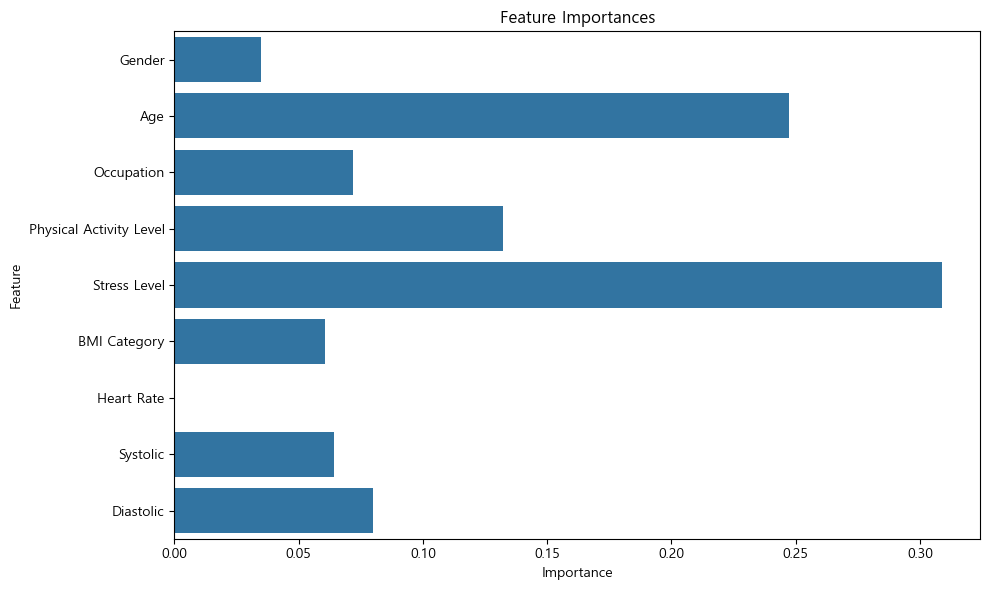

In [26]:
# 4. 피처 중요도 시각화
importances = rf_model.feature_importances_
features = X_train.columns  # X가 아니라 X_train이 더 안전

plt.figure(figsize=(10, 6))
sns.barplot(x=importances, y=features)
plt.title("Feature Importances")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()


--- 학습 곡선 ---


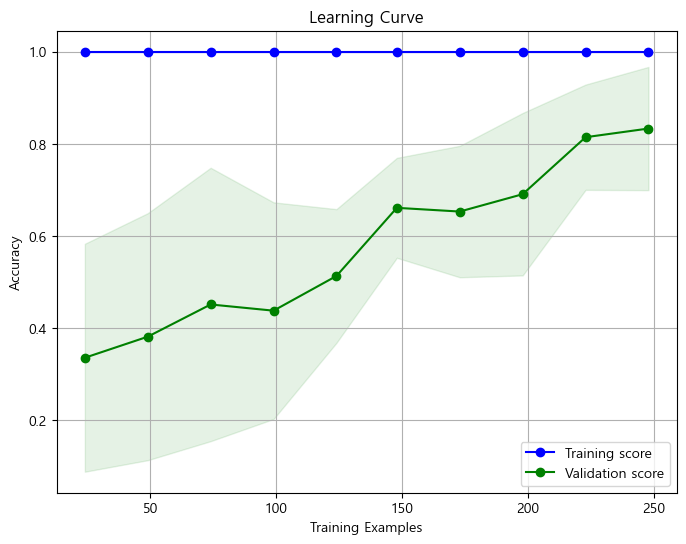


--- 교차 검증 점수 ---
Cross-validation scores: [0.91129032 0.94354839 0.64516129]
Mean CV accuracy: 0.8333, Std: 0.1337


In [27]:
# --- 8. 학습 곡선 및 교차 검증 점수 ---

# plot_learning_curve 함수 정의
# [설명]: 이 함수는 이전에 주석 처리되어 있던 것이 아니라, 별도로 정의되어 있어야 합니다.
# 이 코드를 코드의 상단 (임포트 아래, 다른 함수들과 함께)에 두는 것을 권장합니다.
def plot_learning_curve(estimator, X, y, cv=5, scoring='accuracy'):
    train_sizes, train_scores, val_scores = learning_curve(
        estimator, X, y, cv=cv, scoring=scoring, n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 10)
    )
    
    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    val_mean = np.mean(val_scores, axis=1)
    val_std = np.std(val_scores, axis=1)
    
    plt.figure(figsize=(8,6))
    plt.plot(train_sizes, train_mean, 'o-', color='blue', label='Training score')
    plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1, color='blue')
    plt.plot(train_sizes, val_mean, 'o-', color='green', label='Validation score')
    plt.fill_between(train_sizes, val_mean - val_std, val_mean + val_std, alpha=0.1, color='green')
    
    plt.title('Learning Curve')
    plt.xlabel('Training Examples')
    plt.ylabel(scoring.capitalize())
    plt.legend(loc='best')
    plt.grid()
    plt.show() # 차트를 주피터에 표시

# --- 학습 곡선 출력 ---
print("\n--- 학습 곡선 ---")
# [설명]: 이미 학습된 rf_model과 X_model, y_model을 사용하여 학습 곡선을 그립니다.
plot_learning_curve(rf_model, X_model, y_model, cv=3)

# --- 교차 검증 점수 출력 ---
print("\n--- 교차 검증 점수 ---")
# [설명]: 이미 학습된 rf_model과 X_model, y_model을 사용하여 교차 검증 점수를 계산합니다.
scores = cross_val_score(rf_model, X_model, y_model, cv=3, scoring='accuracy')
print(f"Cross-validation scores: {scores}")
print(f"Mean CV accuracy: {scores.mean():.4f}, Std: {scores.std():.4f}")

# [삭제 필요]: 이 부분은 기존 코드에서 불필요한 중복입니다.
# # 데이터 분리 (X, y는 미리 준비된 상태여야 함)
# X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
# # 모델 생성 및 학습
# model = RandomForestClassifier(random_state=42)
# model.fit(X_train, y_train)

# 군집

## 필요 없는 데이터 제거

In [28]:
# [핵심]: 군집 분석에는 이상치를 제거하지 않은 '원본 df'를 사용합니다.
# 'Quality of Sleep' 컬럼 제거 (군집화 대상이 아니므로)
X_cluster = df.drop(columns=['Quality of Sleep', 'gubun'], errors='ignore') # 'gubun' 컬럼을 X_cluster에서 제거합니다.

## 순수 수치형 컬럼, 레이블 인코딩된 범주형 컬럼 명확히 구분

In [29]:
#    - 'Gender', 'Occupation', 'BMI Category'는 레이블 인코딩된 범주형입니다.
#    - 나머지는 순수 수치형입니다.
label_encoded_categorical_cols = ['Gender', 'Occupation', 'BMI Category'] # 레이블 인코딩된 범주형 컬럼 목록

## 스케일링할 순수 수치형 컬럼만 선택

In [30]:
numerical_cols_for_clustering = [
    col for col in X_cluster.columns 
    if col not in label_encoded_categorical_cols and X_cluster[col].dtype in [np.int64, np.float64] # 숫자 타입 확인 추가
]

scaler = StandardScaler()
X_cluster_scaled = X_cluster.copy() # 원본 X_cluster 변경 방지 (스케일링 결과를 새 변수에 저장)
X_cluster_scaled[numerical_cols_for_clustering] = scaler.fit_transform(X_cluster_scaled[numerical_cols_for_clustering])
print("\n군집 분석을 위한 순수 수치형 데이터 스케일링 완료.")



군집 분석을 위한 순수 수치형 데이터 스케일링 완료.


## 클러스터링 수행

In [31]:
kmeans = KMeans(n_clusters=3, random_state=42, n_init='auto') # n_init='auto' 권장 설정
# 스케일링된 데이터로 군집화합니다. (X_cluster_scaled 사용)
cluster_labels = kmeans.fit_predict(X_cluster_scaled)

# [수정사항]: 군집 결과를 X_cluster에 'Cluster' 컬럼으로 추가하고, 이 결과를 다시 원본 df에도 병합합니다.
X_cluster['Cluster'] = cluster_labels
df['Cluster'] = cluster_labels # 원본 df에 클러스터 결과 병합 (이후 recommend_sleep 등 분석에서 활용)
print("\n군집 분석 완료. 원본 df에 'Cluster' 컬럼 추가됨.")


군집 분석 완료. 원본 df에 'Cluster' 컬럼 추가됨.


## 군집 결과 분석 및 시각화

In [32]:
print("\n--- 군집별 평균 특성 (원본 df 기준) ---")
# [설명]: Cluster 컬럼이 추가된 원본 df를 사용하여 군집별 평균 특성을 확인합니다.
# 모든 컬럼에 대해 평균을 볼 수 있지만, 의미 있는 수치형 컬럼 위주로 보는 것이 좋습니다.
display(df.groupby('Cluster').mean(numeric_only=True)) # numeric_only=True 추가하여 경고 방지


# ✔ 방법 1. 범주형 컬럼들의 최빈값(mode) 보기
# [수정사항]: df를 사용하고, cluster_mode는 df의 컬럼 기준으로 생성
# 최빈값은 모든 컬럼 (수치형, 레이블 인코딩된 범주형)에 대해 볼 수 있습니다.
cluster_mode = df.groupby('Cluster').agg(lambda x: x.mode().iloc[0])
print("\n--- 군집별 특성 최빈값 (전체) ---")
pd.set_option('display.max_columns', None) # 모든 컬럼을 표시하도록 설정
display(cluster_mode)


--- 군집별 평균 특성 (원본 df 기준) ---


,Gender,Age,Occupation,Quality of Sleep,Physical Activity Level,Stress Level,BMI Category,Heart Rate,Systolic,Diastolic
Cluster,,,,,,,,,,
0,0.412844,40.045872,1.119266,8.018349,56.256881,4.321101,0.018349,67.605505,120.376147,78.550459
1,0.288591,46.791946,6.973154,6.892617,61.295302,5.651007,1.852349,71.006711,134.657718,89.872483
2,0.870690,38.275862,2.155172,7.189655,59.181034,6.043103,0.241379,71.491379,128.396552,83.672414



--- 군집별 특성 최빈값 (전체) ---


,Gender,Age,Occupation,Quality of Sleep,Physical Activity Level,Stress Level,BMI Category,Heart Rate,Systolic,Diastolic,gubun
Cluster,,,,,,,,,,,
0,0,53,2,8,75,3,0,65,125,80,train
1,0,44,5,6,45,7,2,68,140,95,train
2,1,43,3,8,90,5,0,70,130,85,train


## 범주형 변수의 비율 분석

In [33]:
print("\n--- 군집별 범주형 변수 비율 분포 ---")
# [수정사항]: 원본 df의 'Gender', 'Occupation', 'BMI Category' 컬럼만 명시적으로 사용
# 이 컬럼들은 LabelEncoder로 이미 숫자로 변환되어 있습니다.
display_categorical_cols = ['Gender', 'Occupation', 'BMI Category'] # 분석하고 싶은 원래 범주형 컬럼들을 명시적으로 지정
for col in display_categorical_cols:
    if col in df.columns: # 컬럼이 df에 있는지 확인하는 안전 장치
        print(f'\n[📊 {col} 비율 분포]')
        # pd.crosstab 사용 시 df['Cluster']와 df[col] 모두 숫자이므로 정상 작동
        print(pd.crosstab(df['Cluster'], df[col], normalize='index'))


--- 군집별 범주형 변수 비율 분포 ---

[📊 Gender 비율 분포]
Gender          0         1
Cluster                    
0        0.587156  0.412844
1        0.711409  0.288591
2        0.129310  0.870690

[📊 Occupation 비율 분포]
Occupation        0         1         2         3         4         5   \
Cluster                                                                  
0           0.284404  0.311927  0.403670  0.000000  0.000000  0.000000   
1           0.000000  0.000000  0.000000  0.000000  0.000000  0.449664   
2           0.051724  0.318966  0.163793  0.405172  0.008621  0.051724   

Occupation        6         7         8         9         10  
Cluster                                                       
0           0.000000  0.000000  0.000000  0.000000  0.000000  
1           0.013423  0.214765  0.026846  0.026846  0.268456  
2           0.000000  0.000000  0.000000  0.000000  0.000000  

[📊 BMI Category 비율 분포]
BMI Category         0         1         2
Cluster                                  

## 군집 결과 시각화 (박스플롯)

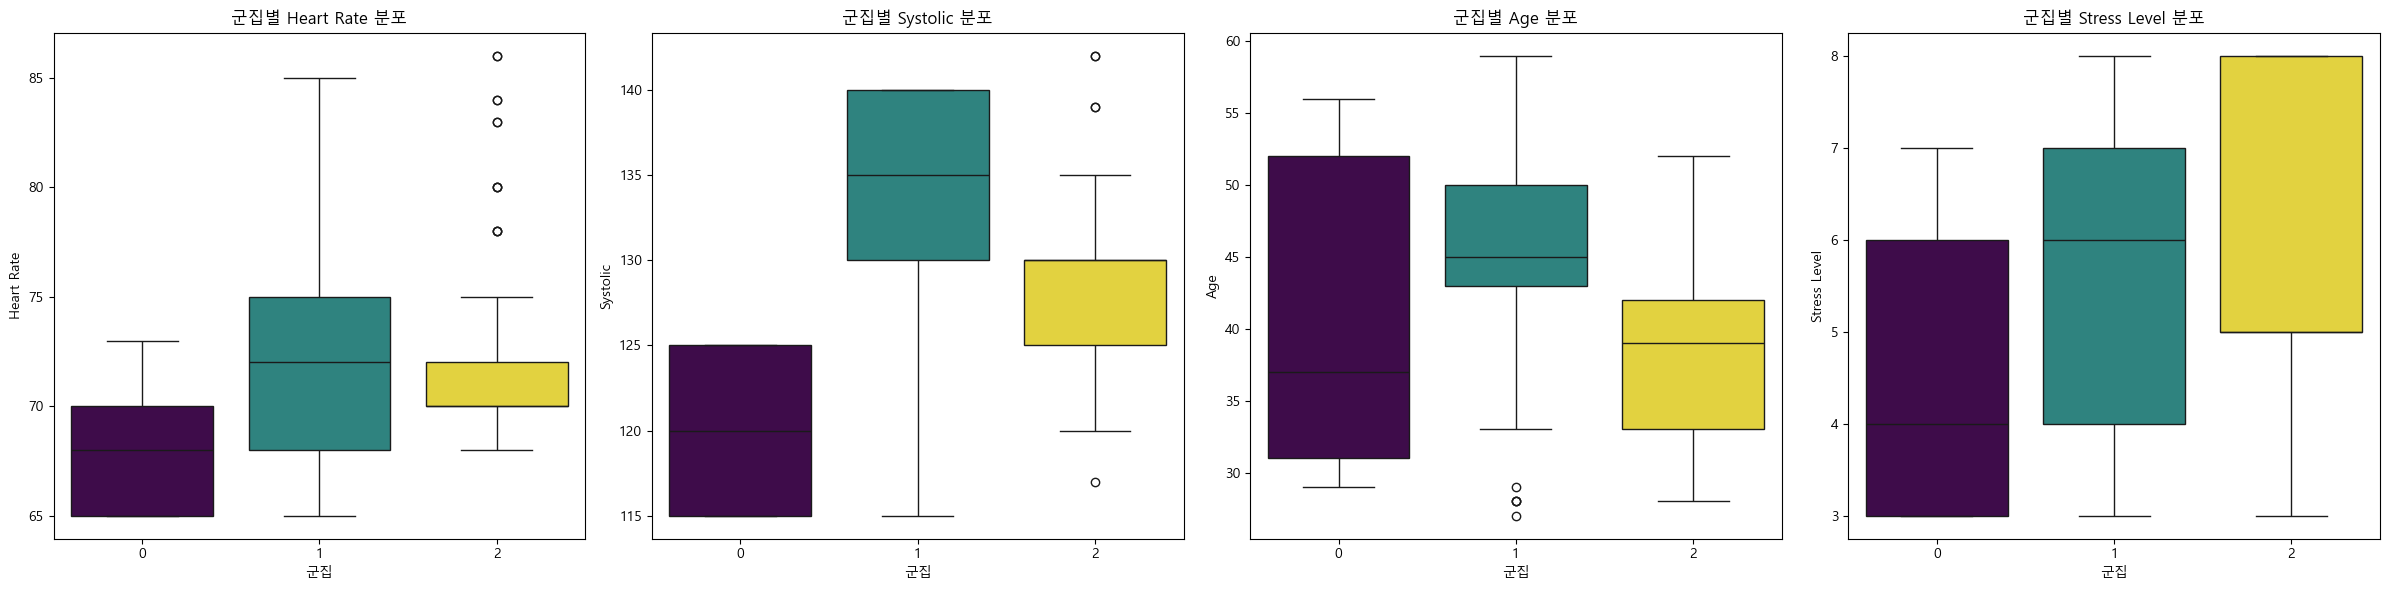

In [34]:

# [설명]: 원본 df에 추가된 'Cluster' 컬럼을 기준으로 박스플롯을 그립니다.
cols_to_plot_after_cluster = ['Heart Rate', 'Systolic', 'Age', 'Stress Level'] # 시각화할 피처 목록
fig, axes = plt.subplots(nrows=1, ncols=len(cols_to_plot_after_cluster), figsize=(len(cols_to_plot_after_cluster)*6, 6))

if len(cols_to_plot_after_cluster) == 1:
    axes = [axes] # 컬럼이 하나일 경우 axes가 단일 객체이므로 리스트로 감싸서 반복문 사용 가능하게 함

for i, col in enumerate(cols_to_plot_after_cluster):
    sns.boxplot(x="Cluster", y=col, data=df, ax=axes[i], palette='viridis', hue='Cluster', legend=False)
    axes[i].set_title(f"군집별 {col} 분포", fontsize=12)
    axes[i].set_xlabel("군집", fontsize=10)
    axes[i].set_ylabel(col, fontsize=10)
plt.tight_layout()
plt.show() # 차트 표시

## 실루엣 스코어 확인

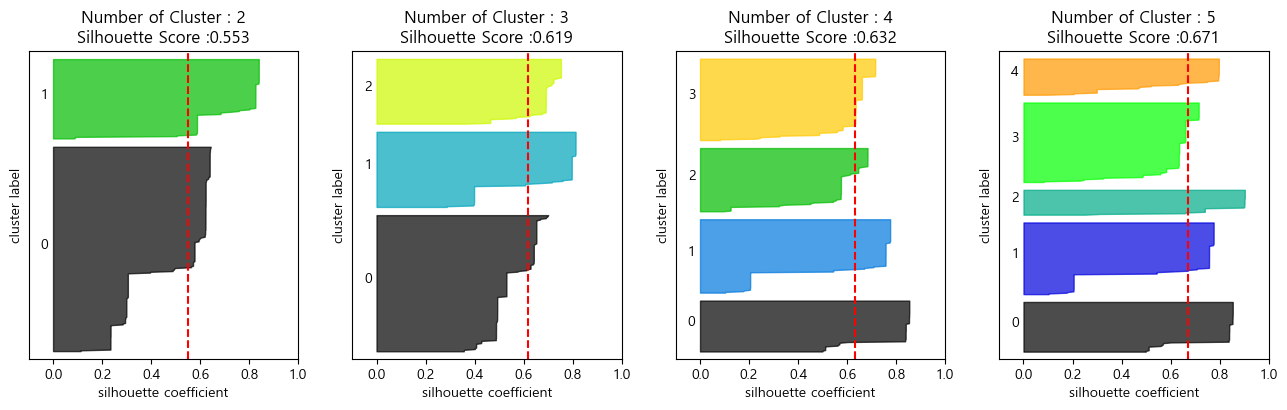

In [35]:

def my_chart(cluster_lists, X): 
    
    fig, axs = plt.subplots(figsize=(4*len(cluster_lists), 4), 
                            nrows=1, 
                            ncols=len(cluster_lists))

    for ind, k in enumerate(cluster_lists):
        
        kmeans = KMeans(n_clusters=k, max_iter=500, random_state=1111) 
        cluster_labels = kmeans.fit_predict(X)
        
        sil_coef_mean = silhouette_score(X, cluster_labels)
        sil_coef      = silhouette_samples(X, cluster_labels)
        
        y_lower = 10
        axs[ind].set_title('Number of Cluster : '+ str(k)+'\n' \
                          'Silhouette Score :' + str(round(sil_coef_mean,3)) )

        axs[ind].set_xlabel("silhouette coefficient")
        axs[ind].set_ylabel("cluster label")
        axs[ind].set_xlim([-0.1, 1])
        axs[ind].set_ylim([0, len(X) + (k + 1) * 10])
        axs[ind].set_yticks([])  # Clear the yaxis labels / ticks
        axs[ind].set_xticks([0, 0.2, 0.4, 0.6, 0.8, 1])

        # 클러스터링 막대 그래프
        for i in range(k):
            ith_cluster_sil_coef = sil_coef[cluster_labels==i]
            ith_cluster_sil_coef.sort()

            size_cluster_i = ith_cluster_sil_coef.shape[0]
            y_upper = y_lower + size_cluster_i

            color = cm.nipy_spectral(float(i) / k)
            axs[ind].fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_sil_coef, \
                                facecolor=color, edgecolor=color, alpha=0.7)
            axs[ind].text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
            y_lower = y_upper + 10

        axs[ind].axvline(x=sil_coef_mean, color="red", linestyle="--")

# 호출할 때
my_chart([2,3,4,5], X)


## 엘보차트 그리기

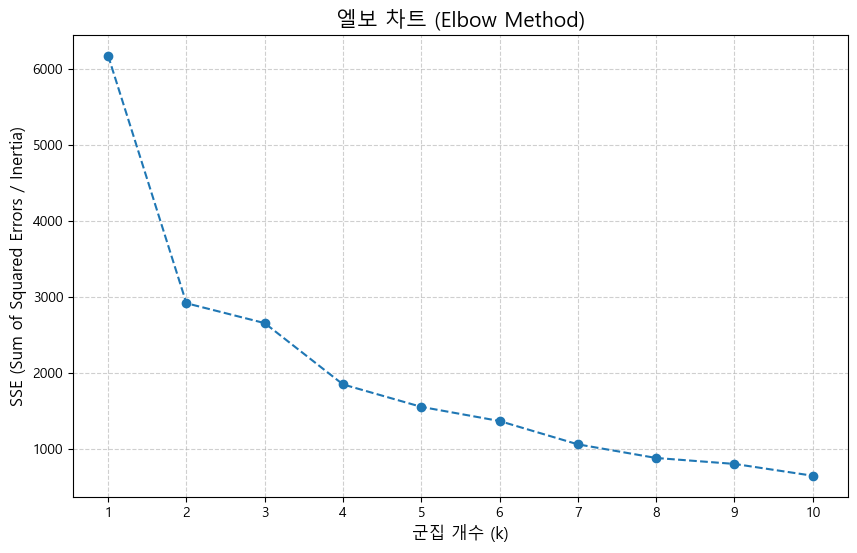


엘보 차트가 생성되었습니다. SSE 값이 급격히 줄어들다가 완만해지는 '팔꿈치' 지점을 찾아보세요.


In [36]:
# [설명]: K-Means에서 최적의 군집 개수(k)를 찾기 위한 엘보 차트를 그립니다.

# 군집 개수(k) 범위 설정
max_k = 10 # 테스트할 최대 군집 개수
sse = [] # 각 k에 대한 SSE(Sum of Squared Errors) 값을 저장할 리스트

# 각 k 값에 대해 K-Means 수행 및 SSE 계산
for k in range(1, max_k + 1):
    kmeans = KMeans(n_clusters=k, random_state=42, n_init='auto')
    kmeans.fit(X_cluster_scaled) # 스케일링된 데이터 사용
    sse.append(kmeans.inertia_) # inertia_ 속성이 SSE 값입니다.

# 엘보 차트 시각화
plt.figure(figsize=(10, 6))
plt.plot(range(1, max_k + 1), sse, marker='o', linestyle='--')
plt.title('엘보 차트 (Elbow Method)', fontsize=15)
plt.xlabel('군집 개수 (k)', fontsize=12)
plt.ylabel('SSE (Sum of Squared Errors / Inertia)', fontsize=12)
plt.xticks(range(1, max_k + 1)) # x축 눈금 설정
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

print("\n엘보 차트가 생성되었습니다. SSE 값이 급격히 줄어들다가 완만해지는 '팔꿈치' 지점을 찾아보세요.")

## 다양한 K 값에 따른 2D 군집 산점도 시각화

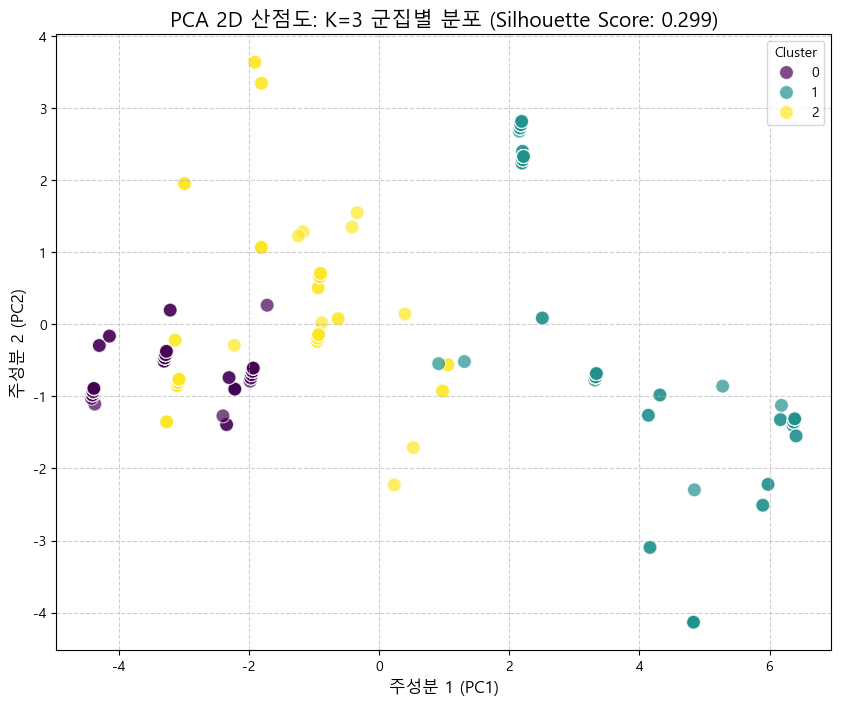

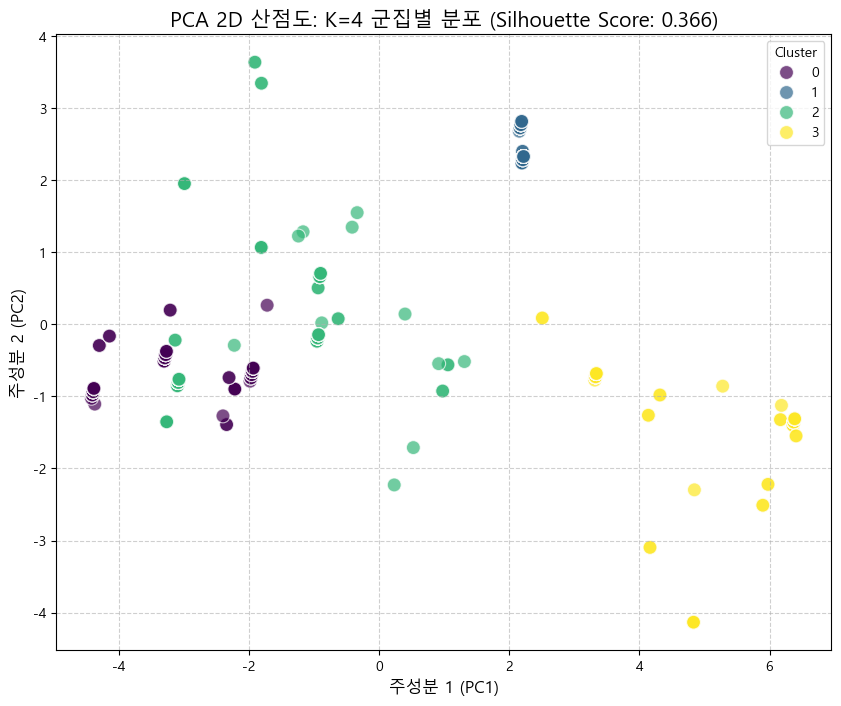

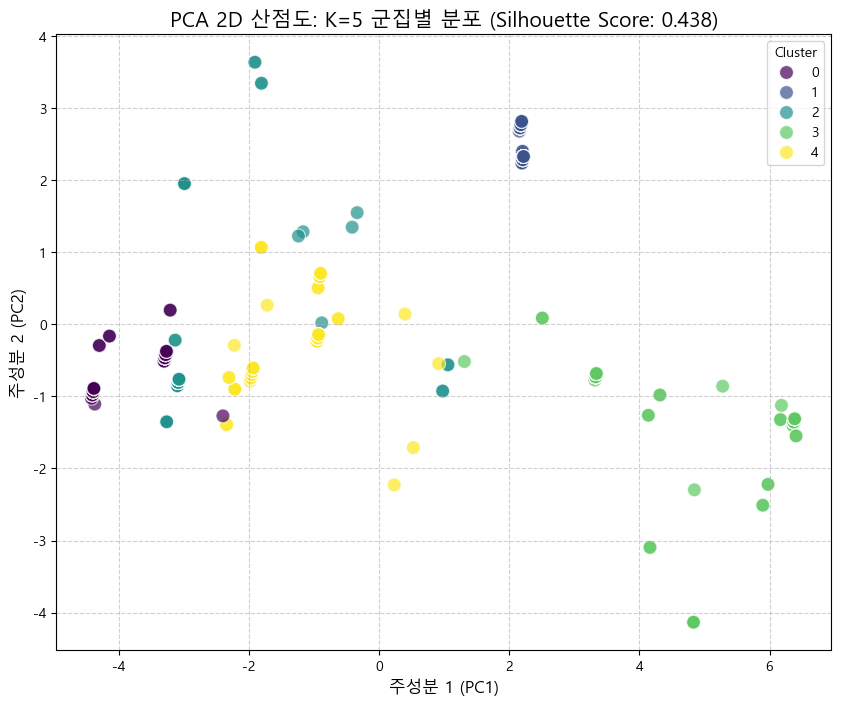


K=3, 4, 5일 때의 PCA 2D 산점도가 각각 생성되었습니다. 각 군집의 응집도와 분리도를 시각적으로 비교해보세요.


In [37]:
# [설명]: k=3, 4, 5일 때 각각 PCA를 이용한 2차원 산점도를 그려 군집 응집도를 시각적으로 비교합니다.
from sklearn.decomposition import PCA # PCA 임포트 (상단에 이미 임포트되어 있어야 함)

# 테스트할 k 값 리스트
k_values_to_plot = [3, 4, 5]

# 각 k 값에 대해 산점도 그리기
for k in k_values_to_plot:
    # 1. K-Means 군집화 수행 (스케일링된 데이터 X_cluster_scaled 사용)
    kmeans = KMeans(n_clusters=k, random_state=42, n_init='auto')
    cluster_labels = kmeans.fit_predict(X_cluster_scaled)
    
    # 2. 실루엣 점수 계산 (응집도 지표)
    silhouette_avg = silhouette_score(X_cluster_scaled, cluster_labels)
    
    # 3. PCA를 이용해 2차원으로 차원 축소 (군집화에 사용했던 스케일링된 데이터 사용)
    pca = PCA(n_components=2, random_state=42)
    X_pca = pca.fit_transform(X_cluster_scaled)
    
    # 4. PCA 결과와 군집 라벨을 포함하는 데이터프레임 생성
    # X_pca의 첫 번째 주성분을 'PC1', 두 번째 주성분을 'PC2'로 이름 붙입니다.
    # 'Cluster' 정보는 해당 k값의 cluster_labels를 사용합니다.
    pca_df = pd.DataFrame(data=X_pca, columns=['PC1', 'PC2'])
    pca_df['Cluster'] = cluster_labels # 해당 k값의 클러스터 라벨을 pca_df에 추가
    
    # 5. 군집별 산점도 시각화
    plt.figure(figsize=(10, 8))
    sns.scatterplot(x='PC1', y='PC2', hue='Cluster', data=pca_df, 
                    palette='viridis', s=100, alpha=0.7,
                    legend='full') # 'legend=full'로 범례를 명확하게 표시
    
    plt.title(f'PCA 2D 산점도: K={k} 군집별 분포 (Silhouette Score: {silhouette_avg:.3f})', fontsize=15)
    plt.xlabel('주성분 1 (PC1)', fontsize=12)
    plt.ylabel('주성분 2 (PC2)', fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.show() # 차트를 주피터에 표시

print("\nK=3, 4, 5일 때의 PCA 2D 산점도가 각각 생성되었습니다. 각 군집의 응집도와 분리도를 시각적으로 비교해보세요.")

## StandardScaler로 스케일링

In [38]:
# 예를 들어, 원본 df에서 군집에 사용할 컬럼만 뽑아 df_cluster 생성
use_cols = ['Gender', 'Occupation', 'BMI Category', 'gubun', 'Age', 'Heart Rate', 'Stress Level']  # 예시
df_cluster = df[use_cols].copy()

# 이제 수치형 컬럼만 추출 가능
categorical_cols = ['Gender', 'Occupation', 'BMI Category', 'gubun']
numerical_cols = [col for col in df_cluster.columns if col not in categorical_cols]


scaler = StandardScaler()
df_cluster[numerical_cols] = scaler.fit_transform(df_cluster[numerical_cols])

print("스케일링된 수치형 변수 샘플:")
print(df_cluster[numerical_cols].head())


스케일링된 수치형 변수 샘플:
        Age  Heart Rate  Stress Level
0 -1.753096    1.654719      0.347021
1 -1.637643    1.170474      1.475592
2 -1.637643    1.170474      1.475592
3 -1.637643    3.591698      1.475592
4 -1.637643    3.591698      1.475592


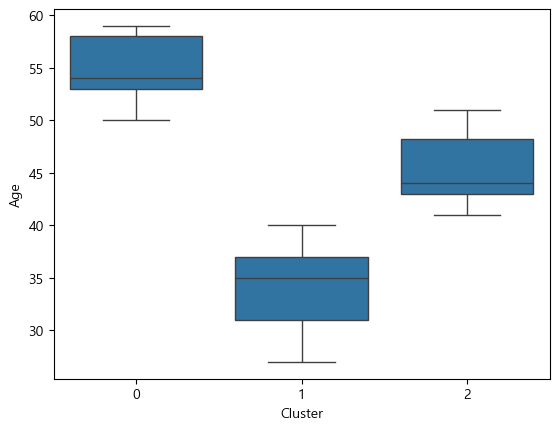

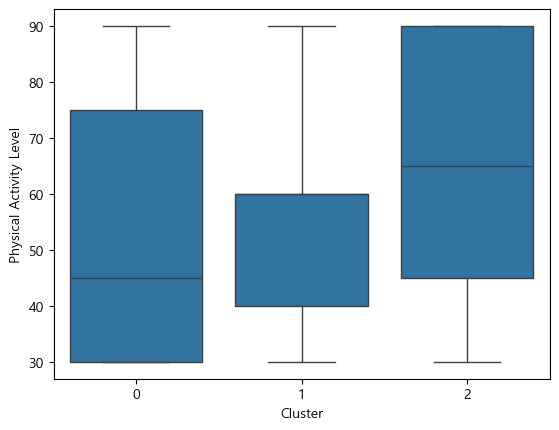

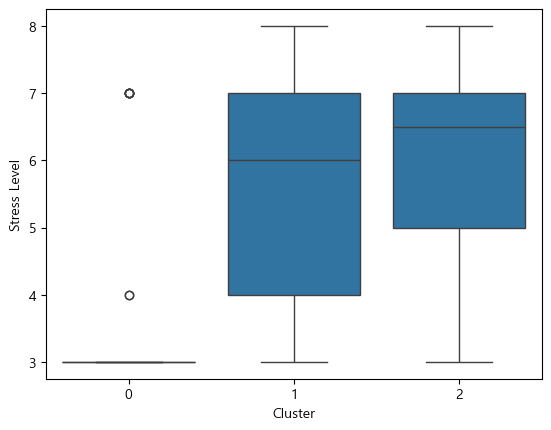

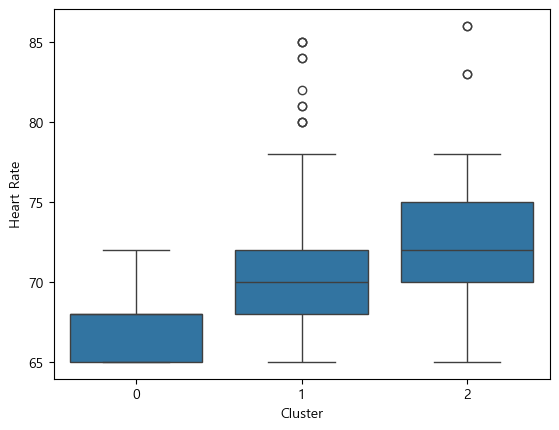

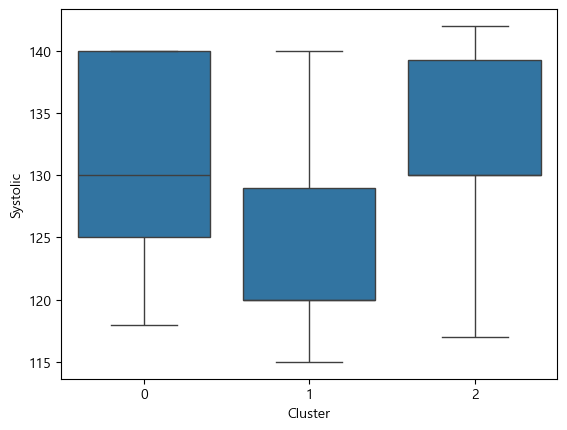

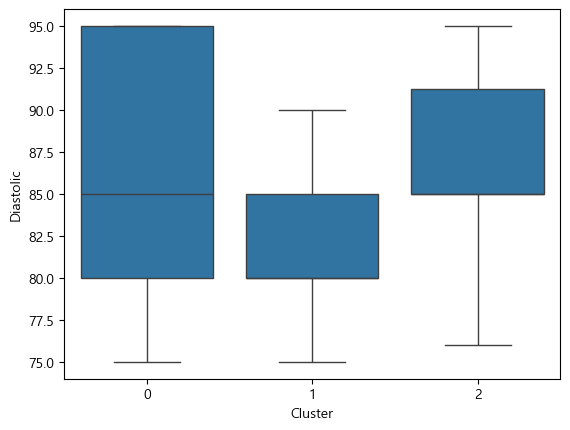

In [39]:

# 1. 군집화는 아래처럼 진행
# 원본 df가 아닌, 이상치가 제거된 df_clean을 사용합니다.
X_cluster = df[['Gender', 'Occupation', 'BMI Category', 'Age', 'Heart Rate', 'Stress Level']]

kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)

# ★★ 핵심: 군집 결과를 df가 아닌 df_clean에 추가합니다.
df['Cluster'] = kmeans.fit_predict(X_cluster)

# 주요 변수 시각화 (예: 박스 플롯)
features_to_plot = ['Age', 'Physical Activity Level', 'Stress Level', 'Heart Rate', 'Systolic', 'Diastolic']

for feature in features_to_plot:
    if feature in df.columns:  # df 대신 df_clean에서 컬럼 확인
        fig, ax = plt.subplots()
        
        # ★★ 핵심: data를 df가 아닌 df_clean으로 변경합니다.
        sns.boxplot(x='Cluster', y=feature, data=df, ax=ax)
        
        # st.pyplot(fig)
        plt.show() 

# Streamlit 대시보드를 만들기

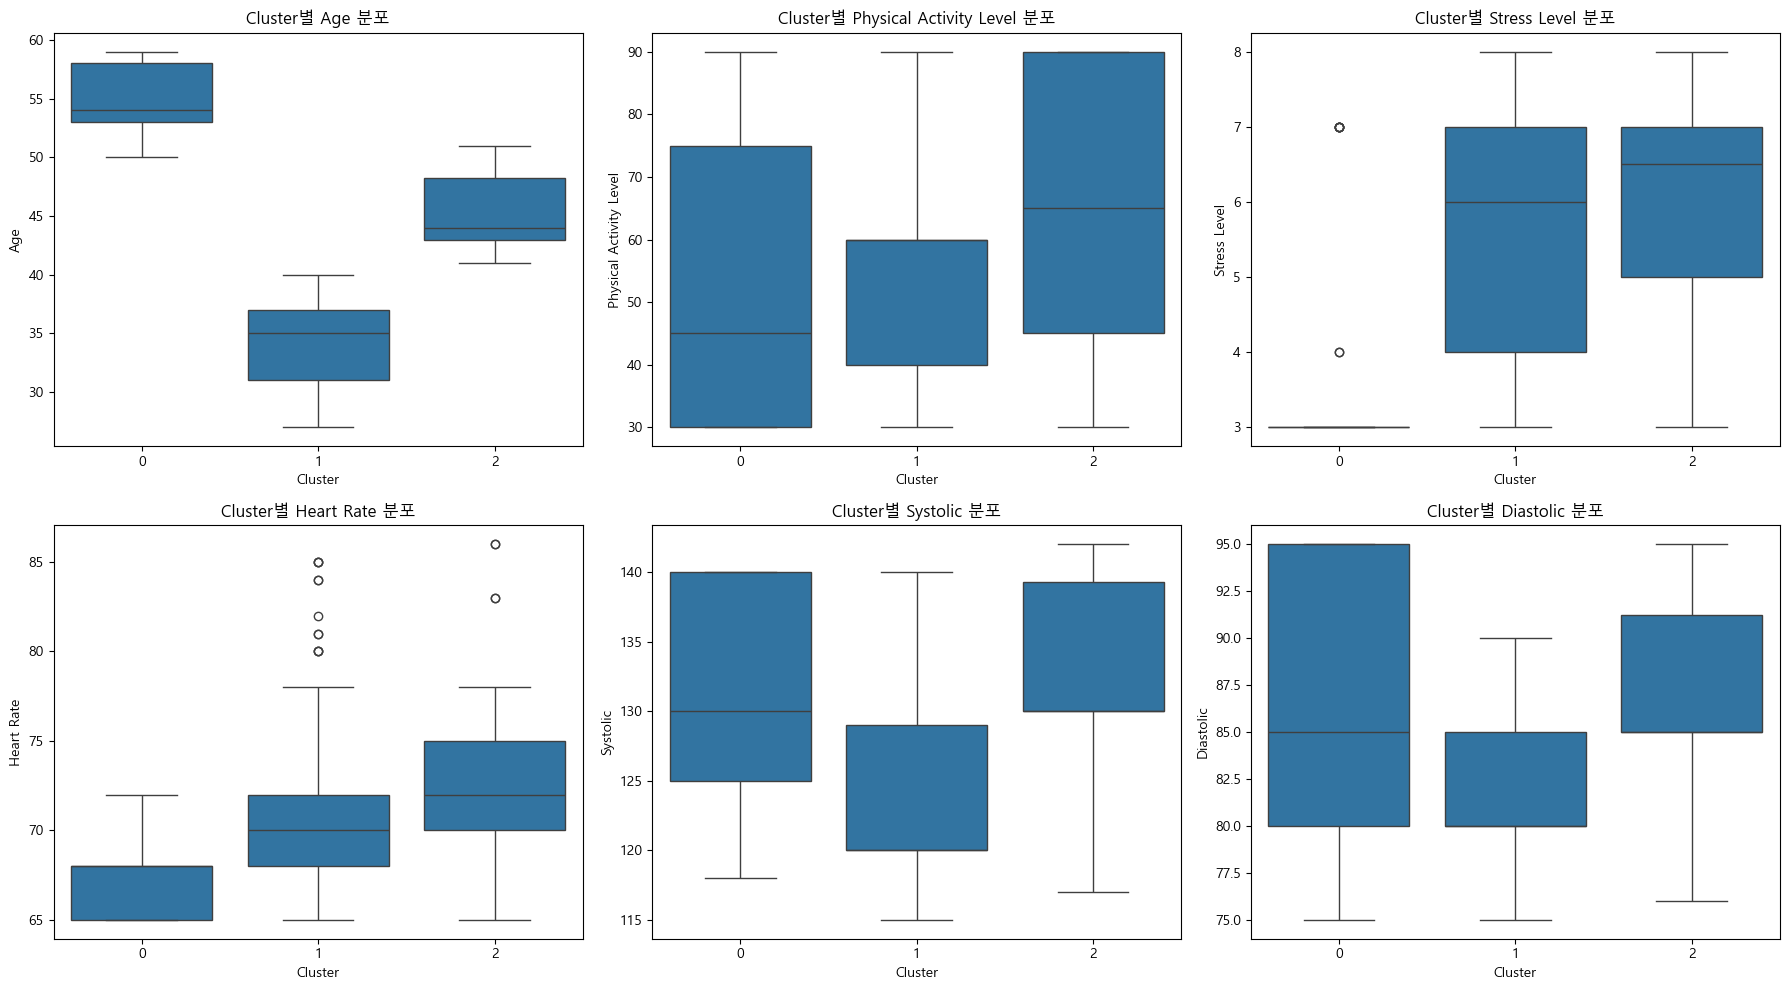

In [40]:

# 시각화할 변수 리스트
features_to_plot = ['Age', 'Physical Activity Level', 'Stress Level', 'Heart Rate', 'Systolic', 'Diastolic']

# 격자(Grid) 설정: 2행 3열
rows = 2
cols = 3
fig, axes = plt.subplots(rows, cols, figsize=(18, 10))
axes = axes.flatten()

for i, feature in enumerate(features_to_plot):
    # ★★ 핵심 수정 사항 ★★
    # 원본 df가 아닌, 이상치를 제거하고 Cluster 컬럼이 추가된 'df_clean'을 사용합니다.
    if feature in df.columns:
        ax = axes[i]
        sns.boxplot(x='Cluster', y=feature, data=df, ax=ax) # <--- 이 부분을 df_clean으로 변경!
        ax.set_title(f'Cluster별 {feature} 분포')
        ax.set_xlabel('Cluster')
        ax.set_ylabel(feature)

# 남는 subplot이 있다면 숨김 처리
for j in range(len(features_to_plot), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
# plt.show()

## Streamlit 대시보드 구현

In [41]:
# st.title('수면 건강 맞춤형 군집 분석 대시보드')

# st.write("""
# 사용자들의 건강 데이터를 바탕으로 3개의 그룹으로 군집화한 결과입니다. 
# 아래에서 관심 있는 그룹을 선택하여 상세 특징을 확인하고 맞춤형 건강 솔루션을 얻어보세요.
# """)

# # 군집 선택 박스
# cluster_option = st.selectbox('분석할 군집을 선택하세요:', sorted(df['Cluster'].unique()))

def recommend_sleep(cluster_id):
    if cluster_id == 0:
        return (
            "현재 스트레스 관리는 잘 되고 있지만, 심박수와 혈압 수치가 다소 높은 경향을 보입니다. "
            "이는 심혈관 건강에 주의가 필요하다는 신호일 수 있습니다. "
            "**매일 30분 이상 걷기, 조깅, 자전거와 같은 유산소 운동**을 통해 심장 건강을 증진시키는 것을 추천합니다. "
            "또한, 식단에서 나트륨 섭취를 줄이는 것도 도움이 됩니다."
        )
    elif cluster_id == 1:
        return (
            "연령대가 높으면서 스트레스와 심박수 모두 높은 수치를 보이는 그룹입니다. "
            "수면의 질을 높이고 건강한 노년을 위해 **규칙적인 생활 패턴과 스트레스 관리**가 매우 중요합니다. "
            "가벼운 아침 스트레칭이나 명상을 시도해 보시고, **매일 같은 시간에 잠자리에 드는 것**만으로도 큰 도움이 될 수 있습니다. "
            "정기적인 혈압 체크도 잊지 마세요."
        )
    elif cluster_id == 2:
        return (
            "젊은 연령대임에도 불구하고 모든 그룹 중 스트레스 지수가 가장 높게 나타났습니다. "
            "이는 만성 피로와 수면 장애의 주된 원인이 될 수 있습니다. "
            "**잠들기 1시간 전에는 스마트폰이나 컴퓨터 사용을 중단**하고, "
            "따뜻한 차를 마시거나 잔잔한 음악을 듣는 등 **'수면 의식'**을 만들어 긴장을 푸는 것이 시급합니다. "
            "주말에는 가벼운 취미 활동으로 스트레스에서 벗어나는 시간을 꼭 가지세요."
        )
    else:
        return "분석된 군집 정보가 없습니다."

df['Recommendation'] = df['Cluster'].apply(recommend_sleep)
plt.show() # 차트 표시


## 군집별 박스 플롯 시각화

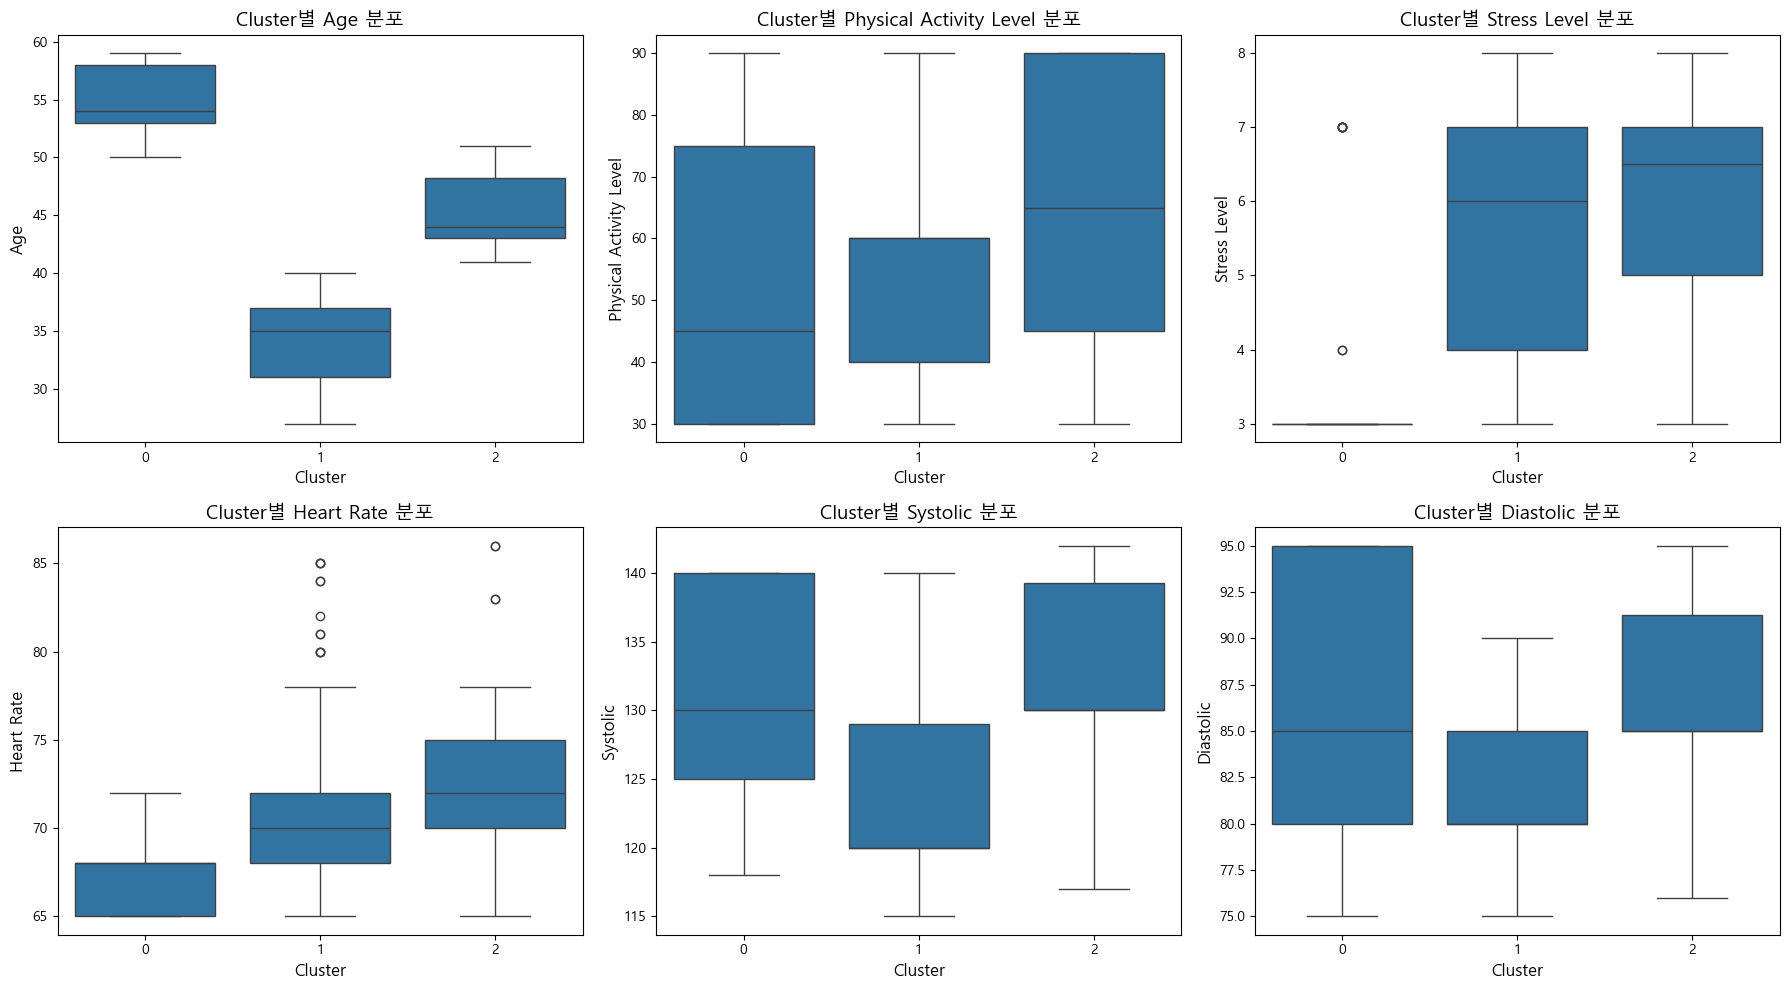

In [42]:
# # 군집별 박스 플롯 시각화
# st.header("군집별 주요 건강 지표 분포 비교")

features_to_plot = ['Age', 'Physical Activity Level', 'Stress Level', 'Heart Rate', 'Systolic', 'Diastolic']

# 격자(Grid) 설정: 2행 3열
rows = 2
cols = 3
fig, axes = plt.subplots(rows, cols, figsize=(18, 10))
axes = axes.flatten()

for i, feature in enumerate(features_to_plot):
    ax = axes[i]
    sns.boxplot(x='Cluster', y=feature, data=df, ax=ax)
    ax.set_title(f'Cluster별 {feature} 분포', fontsize=14)
    ax.set_xlabel('Cluster', fontsize=12)
    ax.set_ylabel(feature, fontsize=12)

plt.tight_layout()

# 완성된 전체 그림(fig)을 대시보드에 출력
# st.pyplot(fig)
plt.show() # 차트 표시
